In [ ]:
# !pip install staintools
# !pip install spams
# !pip install efficientnet_pytorch
# !pip install pretty-confusion-matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%matplotlib inline
import os
import pytz
import pickle
import datetime
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

SEED = 1234

In [ ]:
# import file from drive
from google.colab import drive
drive.mount('/content/drive')

if os.getcwd() == '/content':
    os.chdir('drive/MyDrive/Research/BreakHis_Dataset')

Mounted at /content/drive


In [ ]:
working_dir = '/content/drive/MyDrive/Research/BreakHis_Dataset/'
fold_data = pd.read_csv(os.path.join(working_dir, 'Folds.csv'))
fold_data['main_type'] = fold_data['filename'].str.extract('(malignant|benign)')
fold_data['sub_type'] = fold_data['filename'].apply(lambda x : x.split('/')[-1].split('-')[0].split('_')[2])
fold_data['filename'] = fold_data['filename'].apply(lambda x : working_dir + '/BreaKHis_v1/' + x)
# fold_data

In [ ]:
# I decided to study only 200x magnification (same magnification with TCGA data 20x).
dataset_200x = fold_data[fold_data.mag == 200].drop('mag', axis=1).reset_index(drop=True)

# find portion train and test of each fold
# fold 2 was chosen because data is equally splitted (train : test = 0.70 : 0.30)
# Threfore, I used fold 2 of 200x data to do preliminary experiments.
dict_portion = {}
folds = [i for i in range(1, 6)]
for fold in folds:
    count_train = len(dataset_200x[(dataset_200x['fold'] == fold) & (dataset_200x['grp'] == 'train')])
    count_test = len(dataset_200x[(dataset_200x['fold'] == fold) & (dataset_200x['grp'] == 'test')])
    portion_train = count_train / (count_train + count_test)
    portion_test = 1 - portion_train
    dict_portion[fold] = [portion_train, portion_test]
# dict_portion
fold2_200x = dataset_200x[dataset_200x.fold==2]
fold2_200x_train = fold2_200x[fold2_200x.grp=='train'].drop(['fold', 'grp'], axis=1).sample(frac=1, random_state=SEED).reset_index(drop=True)
fold2_200x_test = fold2_200x[fold2_200x.grp=='test'].drop(['fold', 'grp'], axis=1).sample(frac=1, random_state=SEED).reset_index(drop=True)

In [ ]:
# open image in training set of fold 2
num = 6
img = Image.open(fold2_200x_train.iloc[num,:].filename)
# print(f'type: {fold2_200x_train.iloc[num,:].main_type}')
# print(f'size: {img_before_norm.size}')
# img

## Color Normalization with SPCN Method

In [ ]:
# # color normalization function
# import staintools
# template_path = '/content/drive/MyDrive/Research/BreakHis_Dataset/template_vah.png'
# def stain_norm(im_ls, name_ls, save_dir):
#     METHOD = 'vahadane'
#     STANDARDIZE_BRIGHTNESS = True
#     target = staintools.read_image(template_path)
#     normalizer = staintools.StainNormalizer(method=METHOD)
#     target = staintools.LuminosityStandardizer.standardize(target)
#     normalizer.fit(target)
#     for image, name in tqdm(zip(im_ls, name_ls)):
#         image_standardized = staintools.LuminosityStandardizer.standardize(image)
#         image_normalized = normalizer.transform(image_standardized)
#         image_normalized = Image.fromarray(image_normalized)
#         image_normalized.save(f'{save_dir}/{name}')

In [ ]:
# # loop for fold 1-5 
# # list_colornorm = [fold1_200x_train, fold1_200x_test, fold2_200x_train, fold2_200x_test, fold3_200x_train, fold3_200x_test, fold4_200x_train, fold4_200x_test, fold5_200x_train, fold5_200x_test]
# # preliminary experiments using only fold 2
# list_colornorm = [fold2_200x_train, fold2_200x_test]
# for round in list_colornorm:
#     str_round = [name for name, obj in globals().items() if id(obj) == id(round)][0]
#     fold = str_round.split('_')[0]
#     train_test = str_round.split('_')[-1]
#     print(fold, train_test)
#     im_ls = []
#     name_ls = []
#     for name in tqdm(round.filename):
#         img = np.array(Image.open(name).convert('RGB'))    
#         im_ls.append(img)
#         name_ls.append(os.path.basename(name))
#     save_dir = f'/content/drive/MyDrive/Research/BreakHis_Dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/color_norm/{fold}/{train_test}/'
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
#     stain_norm(im_ls, name_ls, save_dir)

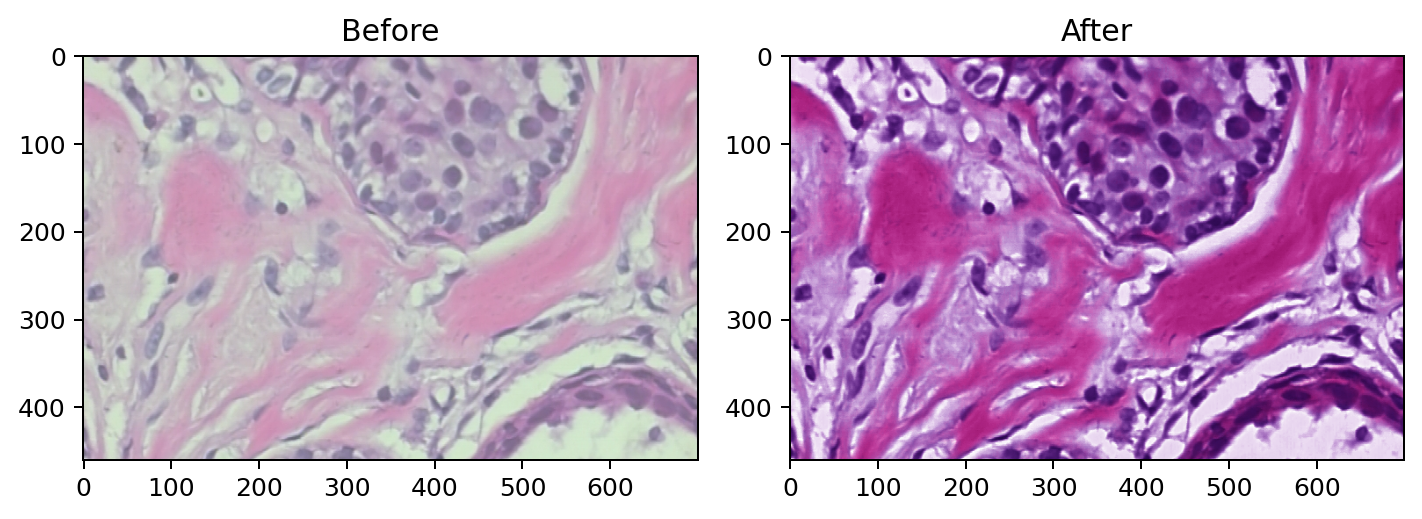

In [ ]:
# show normalization
img_after_norm = Image.open('/content/drive/MyDrive/Research/BreakHis_Dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/color_norm/fold2/train/SOB_B_A-14-22549AB-200-001.png')
img_before_norm = Image.open('/content/drive/MyDrive/Research/BreakHis_Dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-001.png')
fig, axes = plt.subplots(1, 2, figsize=(8, 7.5), dpi=180, tight_layout=True)
axes[0].imshow(img_before_norm)
axes[0].set_title('Before')
axes[1].imshow(img_after_norm)
axes[1].set_title('After')
plt.show()

## Label, Split, Load Data

In [ ]:
color_norm_train_path = '/content/drive/MyDrive/Research/BreakHis_Dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/color_norm/fold2/train/'
color_norm_test_path = '/content/drive/MyDrive/Research/BreakHis_Dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/color_norm/fold2/test/'
fold2_200x_train.filename = fold2_200x_train.filename.apply(lambda x : os.path.join(color_norm_train_path, x.split('/')[-1]))
fold2_200x_test.filename = fold2_200x_test.filename.apply(lambda x : os.path.join(color_norm_test_path, x.split('/')[-1]))

In [ ]:
def return_train_test_Y(train, test):
    labels_train = np.zeros(len(train), dtype='int64')
    labels_test = np.zeros(len(test), dtype='int64')
    for i, data in enumerate(train.main_type):
        if data == 'malignant':
            labels_train[i] = 1
    for i, data in enumerate(test.main_type):
        if data == 'malignant':
            labels_test[i] = 1
    return labels_train, labels_test

fold2_200x_train_Y, fold2_200x_test_Y = return_train_test_Y(fold2_200x_train, fold2_200x_test)

In [ ]:
# split valid from test
fold2_200x_train, fold2_200x_valid, fold2_200x_train_Y, fold2_200x_valid_Y = train_test_split(fold2_200x_train, fold2_200x_train_Y, test_size=1/7, random_state=SEED)
fold2_200x_train.name = 'train'
fold2_200x_valid.name = 'valid'
fold2_200x_test.name = 'test'

# reset index of valid, train set after spliting
fold2_200x_valid.reset_index(drop=True, inplace=True)
fold2_200x_train.reset_index(drop=True, inplace=True)

In [ ]:
# Define class to load and transform image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.RandomResizedCrop(224),  
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()])
        self.T2 = transforms.Compose([
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor()])
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img), self.y[index]
        else: return self.T2(img), self.y[index]

In [ ]:
fold2_train_ds = load_data(fold2_200x_train, fold2_200x_train_Y)
fold2_valid_ds = load_data(fold2_200x_valid, fold2_200x_valid_Y)
fold2_test_ds = load_data(fold2_200x_test, fold2_200x_test_Y)

['malignant', 'malignant', 'malignant', 'benign', 'malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'benign', 'malignant', 'malignant', 'benign', 'malignant', 'benign', 'malignant', 'malignant', 'malignant', 'benign', 'malignant', 'malignant', 'malignant', 'benign', 'benign', 'benign', 'benign', 'malignant', 'benign', 'malignant', 'malignant']


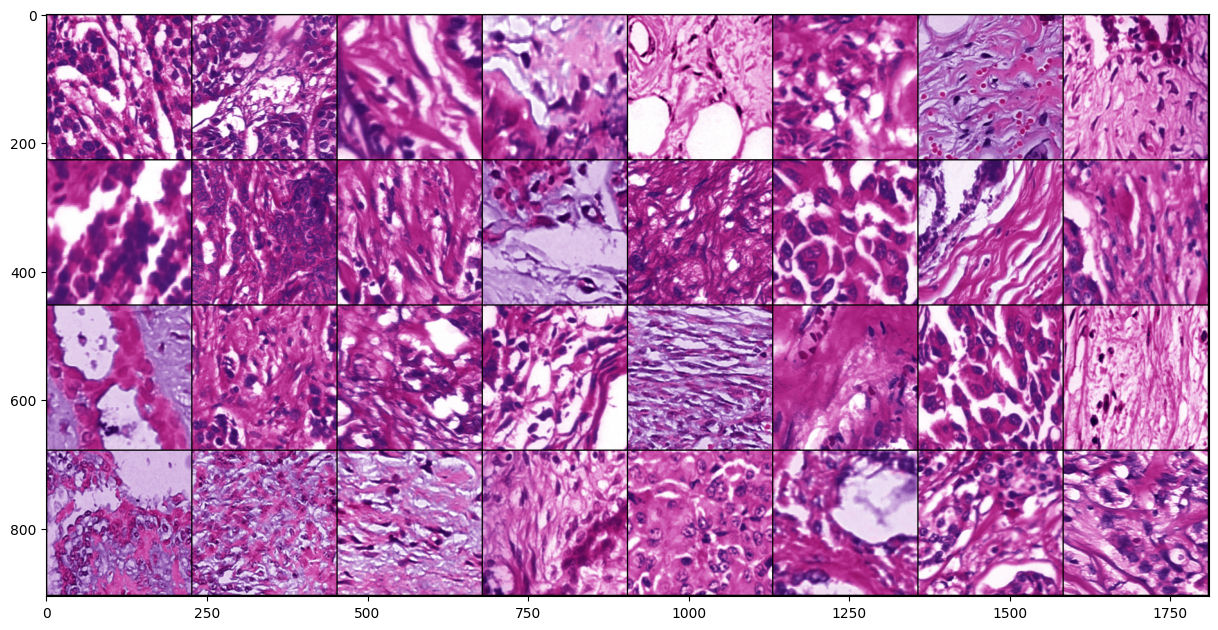

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
train_ds_batch1 = DataLoader(fold2_train_ds, batch_size=32, shuffle=True) 
inputs, classes = next(iter(train_ds_batch1))
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([['benign', 'malignant'][x] for x in classes])

In [ ]:
# # load and save data to pickle file for reproducibility
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train_data = []
# for images, labels in tqdm(fold2_train_ds):
#     images = images.to(device)
#     labels = torch.tensor(labels).to(device)
#     train_data.append((images, labels))

# val_data = []
# for images, labels in tqdm(fold2_valid_ds):
#     images = images.to(device)
#     labels = torch.tensor(labels).to(device)
#     val_data.append((images, labels))

# test_data = []
# for images, labels in tqdm(fold2_test_ds):
#     images = images.to(device)
#     labels = torch.tensor(labels).to(device)
#     test_data.append((images, labels))

# save_pickle_dir = '/content/drive/MyDrive/Research/BreakHis_Dataset/runmodel/fold2_data_load/'
# if not os.path.exists(save_pickle_dir):
#     os.makedirs(save_pickle_dir)

# with open(os.path.join(save_pickle_dir, 'train.pkl'), 'wb') as file:
#     pickle.dump(train_data, file)

# with open(os.path.join(save_pickle_dir, 'valid.pkl'), 'wb') as file:
#     pickle.dump(val_data, file)
    
# with open(os.path.join(save_pickle_dir, 'test.pkl'), 'wb') as file:
#     pickle.dump(test_data, file)

In [ ]:
# Load the train valid test dataset
save_pickle_dir = '/content/drive/MyDrive/Research/BreakHis_Dataset/runmodel/fold2_data_load/'
with open(os.path.join(save_pickle_dir, 'train.pkl'), 'rb') as file:
    train_data = pickle.load(file)

with open(os.path.join(save_pickle_dir, 'valid.pkl'), 'rb') as file:
    val_data = pickle.load(file)

with open(os.path.join(save_pickle_dir, 'test.pkl'), 'rb') as file:
    test_data = pickle.load(file)

## Model Architecture

### ResNet

In [ ]:
class resnet_model(nn.Module):
    def __init__(self, modelname, pretrained=True, freeze=True, dropout_rate_1=0.5, dropout_rate_2=0.5):
        super().__init__()
        self.modelname = modelname
        self.dropout_rate_1 = dropout_rate_1
        self.dropout_rate_2 = dropout_rate_2

        torch.manual_seed(SEED)
        np.random.seed(SEED)

        if self.modelname == 'resnet18':
            resnet = models.resnet18(pretrained=pretrained)
        elif self.modelname == 'resnet34':
            resnet = models.resnet34(pretrained=pretrained)
        elif self.modelname == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
        elif self.modelname == 'resnet101':
            resnet = models.resnet101(pretrained=pretrained)
        elif self.modelname == 'resnet152':
            resnet = models.resnet152(pretrained=pretrained)
        else:
            raise ValueError('Unsupported modelname. Choose from 'resnet18', 'resnet34', 'resnet50', 'resnet101', or 'resnet152'.')
        
        if freeze:
            for param in resnet.parameters():
                param.requires_grad = False

        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1000),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_1),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
        self.model = resnet

    def forward(self, x):
        return self.model(x)

In [ ]:
resnet152 = resnet_model('resnet152')
model = resnet152
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters in the model: {total_params}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 51.0MB/s]


### VGG

In [ ]:
class vgg_model(nn.Module):
    def __init__(self, modelname, pretrained=True, freeze=True, dropout_rate_1=0.5, dropout_rate_2=0.5):
        super().__init__()
        self.modelname = modelname
        self.dropout_rate_1 = dropout_rate_1
        self.dropout_rate_2 = dropout_rate_2

        if self.modelname == 'vgg16':
            vgg = models.vgg16(pretrained=pretrained)
        elif self.modelname == 'vgg19':
            vgg = models.vgg19(pretrained=pretrained)
        else:
            raise ValueError('Unsupported modelname. Choose from 'vgg16' or 'vgg19'.')
        
        if freeze:
            for param in vgg.parameters():
                param.requires_grad = False

        num_ftrs = vgg.classifier[6].in_features
        vgg.classifier[6] = nn.Sequential(
            nn.Linear(num_ftrs, 1000),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_1),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
        self.model = vgg

    def forward(self, x):
        return self.model(x)

### DenseNet

In [ ]:
class densenet_model(nn.Module):
    def __init__(self, modelname, pretrained=True, freeze=True, dropout_rate_1=0.5, dropout_rate_2=0.5):
        super().__init__()
        self.modelname = modelname
        self.dropout_rate_1 = dropout_rate_1
        self.dropout_rate_2 = dropout_rate_2

        if self.modelname == 'densenet121':
            densenet = models.densenet121(pretrained=pretrained)
        elif self.modelname == 'densenet161':
            densenet = models.densenet161(pretrained=pretrained)
        elif self.modelname == 'densenet169':
            densenet = models.densenet169(pretrained=pretrained)
        elif self.modelname == 'densenet201':
            densenet = models.densenet201(pretrained=pretrained)
        else:
            raise ValueError('Unsupported modelname. Choose from 'densenet121', 'densenet169', 'densenet201', or 'densenet161'.')

        if freeze:
            for param in densenet.parameters():
                param.requires_grad = False

        num_ftrs = densenet.classifier.in_features
        densenet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1000),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_1),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

        self.model = densenet

    def forward(self, x):
        return self.model(x)

### AlexNet

In [ ]:
class alexnet_model(nn.Module):
    def __init__(self, pretrained=True, freeze=True, dropout_rate_1=0.5, dropout_rate_2=0.5):
        super().__init__()
        self.modelname = 'alexnet'
        self.dropout_rate_1 = dropout_rate_1
        self.dropout_rate_2 = dropout_rate_2

        alexnet = models.alexnet(pretrained=pretrained)

        if freeze:
            for param in alexnet.parameters():
                param.requires_grad = False

        num_ftrs = alexnet.classifier[6].in_features
        alexnet.classifier[6] = nn.Sequential(
            nn.Linear(num_ftrs, 1000),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_1),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

        self.model = alexnet

    def forward(self, x):
        return self.model(x)

### EfficientNet

In [ ]:
class efficientnet_model(nn.Module):
    def __init__(self, model_name, freeze=True, dropout_rate_1=0.5, dropout_rate_2=0.5):
        super().__init__()
        self.modelname = model_name
        self.dropout_rate_1 = dropout_rate_1
        self.dropout_rate_2 = dropout_rate_2
        
        if self.modelname == 'efficientnet-b0':
            efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        elif self.modelname == 'efficientnet-b7':
            efficientnet = EfficientNet.from_pretrained('efficientnet-b7')
        else:
            raise ValueError('Unsupported model_name')
        
        if freeze:
            for param in efficientnet.parameters():
                param.requires_grad = False

        num_ftrs = efficientnet._fc.in_features
        efficientnet._fc = nn.Sequential(
            nn.Linear(num_ftrs, 1000),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_1),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate_2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
        self.model = efficientnet

    def forward(self, x):
        return self.model(x)

## Construct Model

After trying every model, both freeze and unfreeze, I found that resnet152 performs the best. (roughly hyperparameter tuned) 
- optimizer = optim.AdamW(model.parameters(), lr=0.0001)
- criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.5, 0.80]).to(device))
- scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10, 30, 50], gamma=0.1))

In [ ]:
resnet152 = resnet_model('resnet152', pretrained=True, freeze=True, dropout_rate_1=0.5, dropout_rate_2=0.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = resnet152
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters in the model: {total_params}')

Total parameters in the model: 60771242


## Model Training and Evaluate

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
import datetime
import pytz
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [ ]:
class ModelTrainer:
    def __init__(self, model, train_dataloader, val_dataloader, test_dataloader, model_name, device):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.model_name = model_name
        self.device = device
        self.train_loss_list = []
        self.train_accuracy_list = []
        self.valid_loss_list = []
        self.valid_accuracy_list = []
        self.runmodel_path = '/content/drive/MyDrive/Research/BreakHis_Dataset/runmodel/'

    def train(self, optimizer, scheduler, criterion, num_epochs, patience):
        thai_tz = pytz.timezone('Asia/Bangkok')
        current_datetime = datetime.datetime.now(tz=thai_tz)
        self.datetime_str = current_datetime.strftime('%Y-%m-%d_%H-%M-%S')

        best_valid_loss = float('inf')
        self.best_model_path = None
        counter = 0

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            running_corrects = 0
            
            for images, labels in tqdm(self.train_dataloader):
                optimizer.zero_grad()
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(self.train_dataloader)
            epoch_accuracy = running_corrects / len(self.train_dataloader.dataset)
            self.train_loss_list.append(epoch_loss)
            self.train_accuracy_list.append(epoch_accuracy.item())
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')
            
            # evaluate on validation set
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            
            with torch.no_grad():
                for images, labels in self.val_dataloader:
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct += (predicted == labels).sum().item()
            
            val_loss /= len(self.val_dataloader)
            val_accuracy = val_correct / len(self.val_dataloader.dataset)
            
            self.valid_loss_list.append(val_loss)
            self.valid_accuracy_list.append(val_accuracy)

            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
            
            scheduler.step()


            # early stopping and save model
            if val_loss < best_valid_loss:
                best_valid_loss = val_loss
                counter = 0
                if self.best_model_path is not None:
                    # delete previous model
                    os.remove(self.best_model_path)
                if not os.path.exists(self.runmodel_path + f'{self.model_name}/'):
                    os.makedirs(self.runmodel_path + f'{self.model_name}/')
                self.best_val_accuracy = val_accuracy
                self.best_epoch = epoch
                self.best_model_path = self.runmodel_path + f'{self.model_name}/param-{self.best_epoch}-{self.best_val_accuracy:.4f}-{self.datetime_str}.pt'
                torch.save(self.model.state_dict(), self.best_model_path)
            else:
                counter += 1
                if counter >= patience:
                    print('Early stopping')
                    break

        print(f'Best model saved: {self.best_model_path}')
        return self.best_model_path, self.best_val_accuracy, self.best_epoch

    def evaluate(self, best_model_path):
        self.model.load_state_dict(torch.load(best_model_path))
        self.model.to(self.device)
        self.model.eval()
        true_labels = []
        predicted_probs = []

        with torch.no_grad():
            for images, labels in self.test_dataloader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_probs.extend(probabilities[:, 1].tolist())
                true_labels.extend(labels.tolist())

        true_labels = torch.tensor(true_labels).cpu().numpy()
        predicted_probs = torch.tensor(predicted_probs).cpu().numpy()

        self.accuracy = accuracy_score(true_labels, np.round(predicted_probs))
        self.precision = precision_score(true_labels, np.round(predicted_probs))
        self.recall = recall_score(true_labels, np.round(predicted_probs))
        self.f1 = f1_score(true_labels, np.round(predicted_probs))
        self.auroc = roc_auc_score(true_labels, predicted_probs)
        self.aucpr = average_precision_score(true_labels, predicted_probs)
        
        print(f'Best Valid Accuracy: {self.best_val_accuracy}')
        print(f'Test Accuracy: {self.accuracy}')
        print(f'Precision: {self.precision}')
        print(f'Recall: {self.recall}')
        print(f'F1-score: {self.f1}')
        print(f'AUROC: {self.auroc}')
        print(f'AUCPR: {self.aucpr}')

    def save_results(self):
        store_data = {
            'train_loss': self.train_loss_list,
            'train_accuracy': self.train_accuracy_list,
            'valid_loss': self.valid_loss_list,
            'valid_accuracy': self.valid_accuracy_list,
            'test_result': {'best_valid_accuracy': self.best_val_accuracy, 'test_accuracy': self.accuracy, 'precision': self.precision, 'recall': self.recall, 'f1-score': self.f1, 'auroc': self.auroc, 'aucpr': self.aucpr}
        }
        with open(self.runmodel_path + f'{self.model_name}/results-{self.datetime_str}.pkl', 'wb') as file:
            pickle.dump(store_data, file)
    
    def get_dict_results(self):
        return {'best_valid_accuracy': self.best_val_accuracy, 'test_accuracy': self.accuracy, 'precision': self.precision, 'recall': self.recall, 'f1-score': self.f1, 'auroc': self.auroc, 'aucpr': self.aucpr}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

model_lists = [resnet152]

for model in model_lists:
    model_name = model.modelname
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.5, 0.80]).to(device))
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10, 30, 50], gamma=0.1)

    num_epochs = 200
    patience = 20

    trainer = ModelTrainer(model, train_dataloader, val_dataloader, test_dataloader, model_name, device)
    best_model_path, best_val_accuracy, best_epoch = trainer.train(optimizer, scheduler, criterion, num_epochs, patience)
    print('** Model Evaluation **')
    trainer.evaluate(best_model_path)
    print('** Saving **')
    trainer.save_results()
    print('\n======================================================\n')

100%|██████████| 38/38 [00:01<00:00, 33.28it/s]


Epoch [1/200], Loss: 0.5895630481996035, Accuracy: 0.6793075203895569
Epoch [1/200], Validation Loss: 0.5550193956920079, Validation Accuracy: 0.6798029556650246


100%|██████████| 38/38 [00:01<00:00, 34.53it/s]


Epoch [2/200], Loss: 0.5446449824069676, Accuracy: 0.6784831285476685
Epoch [2/200], Validation Loss: 0.5549103234495435, Validation Accuracy: 0.6798029556650246


100%|██████████| 38/38 [00:01<00:00, 34.30it/s]


Epoch [3/200], Loss: 0.5430931535206343, Accuracy: 0.6784831285476685
Epoch [3/200], Validation Loss: 0.5548762381076813, Validation Accuracy: 0.6798029556650246


100%|██████████| 38/38 [00:01<00:00, 34.49it/s]


Epoch [4/200], Loss: 0.5444432810733193, Accuracy: 0.6784831285476685
Epoch [4/200], Validation Loss: 0.5546322635241917, Validation Accuracy: 0.6798029556650246


100%|██████████| 38/38 [00:01<00:00, 34.52it/s]


Epoch [5/200], Loss: 0.5431720998726393, Accuracy: 0.6784831285476685
Epoch [5/200], Validation Loss: 0.5533801870686668, Validation Accuracy: 0.6798029556650246


100%|██████████| 38/38 [00:01<00:00, 34.47it/s]


Epoch [6/200], Loss: 0.5388720968836233, Accuracy: 0.6784831285476685
Epoch [6/200], Validation Loss: 0.5265201755932399, Validation Accuracy: 0.6798029556650246


100%|██████████| 38/38 [00:01<00:00, 34.50it/s]


Epoch [7/200], Loss: 0.4965438207513408, Accuracy: 0.7221764326095581
Epoch [7/200], Validation Loss: 0.45703840255737305, Validation Accuracy: 0.8078817733990148


100%|██████████| 38/38 [00:01<00:00, 34.48it/s]


Epoch [8/200], Loss: 0.45865513541196523, Accuracy: 0.8178070783615112
Epoch [8/200], Validation Loss: 0.41990324003355844, Validation Accuracy: 0.8768472906403941


100%|██████████| 38/38 [00:01<00:00, 34.43it/s]


Epoch [9/200], Loss: 0.44372069129818364, Accuracy: 0.8425391912460327
Epoch [9/200], Validation Loss: 0.41707387140819, Validation Accuracy: 0.8768472906403941


100%|██████████| 38/38 [00:01<00:00, 34.37it/s]


Epoch [10/200], Loss: 0.4374311731049889, Accuracy: 0.8474856019020081
Epoch [10/200], Validation Loss: 0.4113106514726366, Validation Accuracy: 0.8916256157635468


100%|██████████| 38/38 [00:01<00:00, 34.51it/s]


Epoch [11/200], Loss: 0.4317234723191512, Accuracy: 0.8565540313720703
Epoch [11/200], Validation Loss: 0.4044733728681292, Validation Accuracy: 0.8817733990147784


100%|██████████| 38/38 [00:01<00:00, 34.34it/s]


Epoch [12/200], Loss: 0.4288794931612517, Accuracy: 0.8540807962417603
Epoch [12/200], Validation Loss: 0.40002936124801636, Validation Accuracy: 0.896551724137931


100%|██████████| 38/38 [00:01<00:00, 34.47it/s]


Epoch [13/200], Loss: 0.4322170387757452, Accuracy: 0.8524320125579834
Epoch [13/200], Validation Loss: 0.401881924697331, Validation Accuracy: 0.8916256157635468


100%|██████████| 38/38 [00:01<00:00, 34.51it/s]


Epoch [14/200], Loss: 0.4295464958015241, Accuracy: 0.8540807962417603
Epoch [14/200], Validation Loss: 0.3974294662475586, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.43it/s]


Epoch [15/200], Loss: 0.4179560816601703, Accuracy: 0.8689200282096863
Epoch [15/200], Validation Loss: 0.39850457651274546, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.22it/s]


Epoch [16/200], Loss: 0.42539511228862564, Accuracy: 0.8656224608421326
Epoch [16/200], Validation Loss: 0.3971630845751081, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.44it/s]


Epoch [17/200], Loss: 0.4233818038513786, Accuracy: 0.8615004420280457
Epoch [17/200], Validation Loss: 0.39857534425599234, Validation Accuracy: 0.8916256157635468


100%|██████████| 38/38 [00:01<00:00, 34.50it/s]


Epoch [18/200], Loss: 0.4290166873680918, Accuracy: 0.859851598739624
Epoch [18/200], Validation Loss: 0.3969017139502934, Validation Accuracy: 0.896551724137931


100%|██████████| 38/38 [00:01<00:00, 34.38it/s]


Epoch [19/200], Loss: 0.4297230016244085, Accuracy: 0.8565540313720703
Epoch [19/200], Validation Loss: 0.39842923624174936, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.38it/s]


Epoch [20/200], Loss: 0.4217190703279094, Accuracy: 0.8680956363677979
Epoch [20/200], Validation Loss: 0.39543697237968445, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.26it/s]


Epoch [21/200], Loss: 0.42068007431532206, Accuracy: 0.8689200282096863
Epoch [21/200], Validation Loss: 0.39627322128840853, Validation Accuracy: 0.896551724137931


100%|██████████| 38/38 [00:01<00:00, 34.23it/s]


Epoch [22/200], Loss: 0.4194397189115223, Accuracy: 0.8697444200515747
Epoch [22/200], Validation Loss: 0.39466375964028494, Validation Accuracy: 0.896551724137931


100%|██████████| 38/38 [00:01<00:00, 34.39it/s]


Epoch [23/200], Loss: 0.4232151923995269, Accuracy: 0.8647980093955994
Epoch [23/200], Validation Loss: 0.3961060047149658, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.40it/s]


Epoch [24/200], Loss: 0.4190735330707149, Accuracy: 0.8672712445259094
Epoch [24/200], Validation Loss: 0.3930619146142687, Validation Accuracy: 0.896551724137931


100%|██████████| 38/38 [00:01<00:00, 34.31it/s]


Epoch [25/200], Loss: 0.41940252090755265, Accuracy: 0.8738664388656616
Epoch [25/200], Validation Loss: 0.39495260800634113, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.22it/s]


Epoch [26/200], Loss: 0.420006682213984, Accuracy: 0.8730420470237732
Epoch [26/200], Validation Loss: 0.3938854847635542, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.52it/s]


Epoch [27/200], Loss: 0.4186968191673881, Accuracy: 0.8705688714981079
Epoch [27/200], Validation Loss: 0.3915426475661142, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.34it/s]


Epoch [28/200], Loss: 0.4227480057038759, Accuracy: 0.8647980093955994
Epoch [28/200], Validation Loss: 0.39174152272088186, Validation Accuracy: 0.9113300492610837


100%|██████████| 38/38 [00:01<00:00, 33.93it/s]


Epoch [29/200], Loss: 0.41945463654242066, Accuracy: 0.8730420470237732
Epoch [29/200], Validation Loss: 0.3927674378667559, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.35it/s]


Epoch [30/200], Loss: 0.41350336059143666, Accuracy: 0.8821104764938354
Epoch [30/200], Validation Loss: 0.39284081969942364, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.15it/s]


Epoch [31/200], Loss: 0.41832226671670614, Accuracy: 0.8705688714981079
Epoch [31/200], Validation Loss: 0.3916334680148533, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.33it/s]


Epoch [32/200], Loss: 0.4171176286120164, Accuracy: 0.8763396739959717
Epoch [32/200], Validation Loss: 0.39520650676318575, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.21it/s]


Epoch [33/200], Loss: 0.4250743961647937, Accuracy: 0.8623248338699341
Epoch [33/200], Validation Loss: 0.3946188816002437, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.20it/s]


Epoch [34/200], Loss: 0.41356925274196427, Accuracy: 0.8746908903121948
Epoch [34/200], Validation Loss: 0.39055669733456205, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 30.44it/s]


Epoch [35/200], Loss: 0.4157533277022211, Accuracy: 0.8689200282096863
Epoch [35/200], Validation Loss: 0.39188170433044434, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 30.47it/s]


Epoch [36/200], Loss: 0.41881413914655385, Accuracy: 0.8755152821540833
Epoch [36/200], Validation Loss: 0.3927462824753353, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 32.63it/s]


Epoch [37/200], Loss: 0.41967471257636424, Accuracy: 0.8623248338699341
Epoch [37/200], Validation Loss: 0.3913243498120989, Validation Accuracy: 0.9113300492610837


100%|██████████| 38/38 [00:01<00:00, 34.15it/s]


Epoch [38/200], Loss: 0.4189495750163731, Accuracy: 0.8656224608421326
Epoch [38/200], Validation Loss: 0.39097138813563753, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.43it/s]


Epoch [39/200], Loss: 0.41376202122161265, Accuracy: 0.8722176551818848
Epoch [39/200], Validation Loss: 0.39324950746127535, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 32.21it/s]


Epoch [40/200], Loss: 0.41423116781209646, Accuracy: 0.878812849521637
Epoch [40/200], Validation Loss: 0.38983688184193205, Validation Accuracy: 0.9113300492610837


100%|██████████| 38/38 [00:01<00:00, 32.34it/s]


Epoch [41/200], Loss: 0.4141481550116288, Accuracy: 0.8771640658378601
Epoch [41/200], Validation Loss: 0.38942571197237286, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.39it/s]


Epoch [42/200], Loss: 0.41558174945806203, Accuracy: 0.8779884576797485
Epoch [42/200], Validation Loss: 0.3899535025869097, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.37it/s]


Epoch [43/200], Loss: 0.41908830796417434, Accuracy: 0.8623248338699341
Epoch [43/200], Validation Loss: 0.39332596744809833, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.41it/s]


Epoch [44/200], Loss: 0.42355533728474065, Accuracy: 0.8697444200515747
Epoch [44/200], Validation Loss: 0.3909159856183188, Validation Accuracy: 0.896551724137931


100%|██████████| 38/38 [00:01<00:00, 34.43it/s]


Epoch [45/200], Loss: 0.4150337482753553, Accuracy: 0.8730420470237732
Epoch [45/200], Validation Loss: 0.3953896718365805, Validation Accuracy: 0.896551724137931


100%|██████████| 38/38 [00:01<00:00, 34.37it/s]


Epoch [46/200], Loss: 0.4153501265927365, Accuracy: 0.8722176551818848
Epoch [46/200], Validation Loss: 0.39195004531315397, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.47it/s]


Epoch [47/200], Loss: 0.41970201699357285, Accuracy: 0.8705688714981079
Epoch [47/200], Validation Loss: 0.39230142746652874, Validation Accuracy: 0.9113300492610837


100%|██████████| 38/38 [00:01<00:00, 34.48it/s]


Epoch [48/200], Loss: 0.4135237383215051, Accuracy: 0.8763396739959717
Epoch [48/200], Validation Loss: 0.39003261072295053, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 33.32it/s]


Epoch [49/200], Loss: 0.41987267920845434, Accuracy: 0.8631492257118225
Epoch [49/200], Validation Loss: 0.3940351094518389, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.17it/s]


Epoch [50/200], Loss: 0.41334467655734014, Accuracy: 0.878812849521637
Epoch [50/200], Validation Loss: 0.3912634721824101, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.29it/s]


Epoch [51/200], Loss: 0.41501600961936147, Accuracy: 0.8738664388656616
Epoch [51/200], Validation Loss: 0.3919976694243295, Validation Accuracy: 0.9113300492610837


100%|██████████| 38/38 [00:01<00:00, 34.32it/s]


Epoch [52/200], Loss: 0.4101302019859615, Accuracy: 0.8845837116241455
Epoch [52/200], Validation Loss: 0.39214189989226206, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.45it/s]


Epoch [53/200], Loss: 0.4063537991360614, Accuracy: 0.8837592601776123
Epoch [53/200], Validation Loss: 0.39028756959097727, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.48it/s]


Epoch [54/200], Loss: 0.40905251393192693, Accuracy: 0.8829348683357239
Epoch [54/200], Validation Loss: 0.39443017329488483, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.49it/s]


Epoch [55/200], Loss: 0.41683621626151235, Accuracy: 0.8730420470237732
Epoch [55/200], Validation Loss: 0.3923015126160213, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.45it/s]


Epoch [56/200], Loss: 0.41781664365216303, Accuracy: 0.8697444200515747
Epoch [56/200], Validation Loss: 0.3929668494633266, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.43it/s]


Epoch [57/200], Loss: 0.4148106347573431, Accuracy: 0.8746908903121948
Epoch [57/200], Validation Loss: 0.3930417682443346, Validation Accuracy: 0.9113300492610837


100%|██████████| 38/38 [00:01<00:00, 34.45it/s]


Epoch [58/200], Loss: 0.4131044917985013, Accuracy: 0.8763396739959717
Epoch [58/200], Validation Loss: 0.3943630201475961, Validation Accuracy: 0.9014778325123153


100%|██████████| 38/38 [00:01<00:00, 34.23it/s]


Epoch [59/200], Loss: 0.41905531993037776, Accuracy: 0.8647980093955994
Epoch [59/200], Validation Loss: 0.39269656794411795, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 33.94it/s]


Epoch [60/200], Loss: 0.4208613273344542, Accuracy: 0.8565540313720703
Epoch [60/200], Validation Loss: 0.3926989265850612, Validation Accuracy: 0.9064039408866995


100%|██████████| 38/38 [00:01<00:00, 34.45it/s]


Epoch [61/200], Loss: 0.41505692977654307, Accuracy: 0.8746908903121948
Epoch [61/200], Validation Loss: 0.39141468490873066, Validation Accuracy: 0.9113300492610837
Early stopping
Best model saved: /content/drive/MyDrive/Research/BreakHis_Dataset/runmodel/resnet152/param-40-0.9064-2023-06-09_01-39-59.pt
** Model Evaluation **
Best Valid Accuracy: 0.9064039408866995
Test Accuracy: 0.897822445561139
Precision: 0.9070796460176991
Recall: 0.9557109557109557
F1-score: 0.9307604994324631
AUROC: 0.9523809523809523
AUCPR: 0.9805531734516826
** Saving **




In [ ]:
best_model_path = '/content/drive/MyDrive/Research/BreakHis_Dataset/runmodel/resnet152/param-40-0.9064-2023-06-09_01-39-59.pt'
resnet152.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

## Evaluate Model

In [ ]:
results_file = '/content/drive/MyDrive/Research/BreakHis_Dataset/runmodel/resnet152/results-2023-06-09_01-39-59.pkl'
import pickle
with open(results_file, 'rb') as file:
    results = pickle.load(file)

train_loss_list = results['train_loss'] 
valid_loss_list = results['valid_loss'] 
train_accuracy_list = results['train_accuracy'] 
valid_accuracy_list = results['valid_accuracy'] 
print(results['test_result'])

{'best_valid_accuracy': 0.9064039408866995, 'test_accuracy': 0.897822445561139, 'precision': 0.9070796460176991, 'recall': 0.9557109557109557, 'f1-score': 0.9307604994324631, 'auroc': 0.9523809523809523, 'aucpr': 0.9805531734516826}


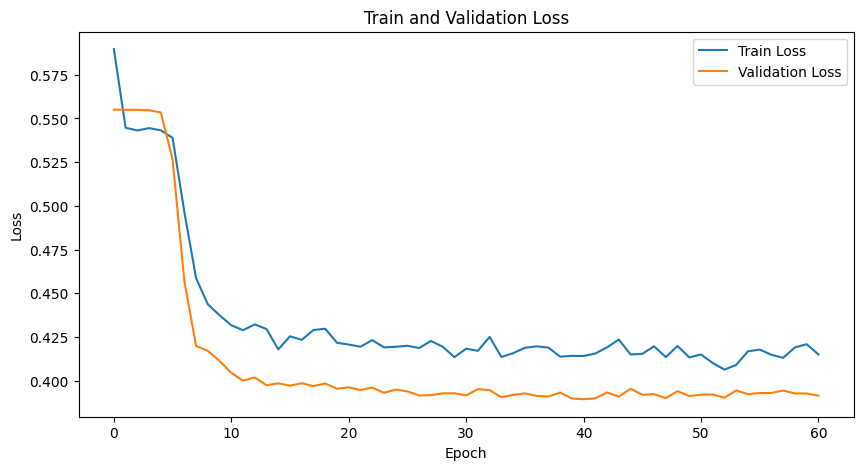

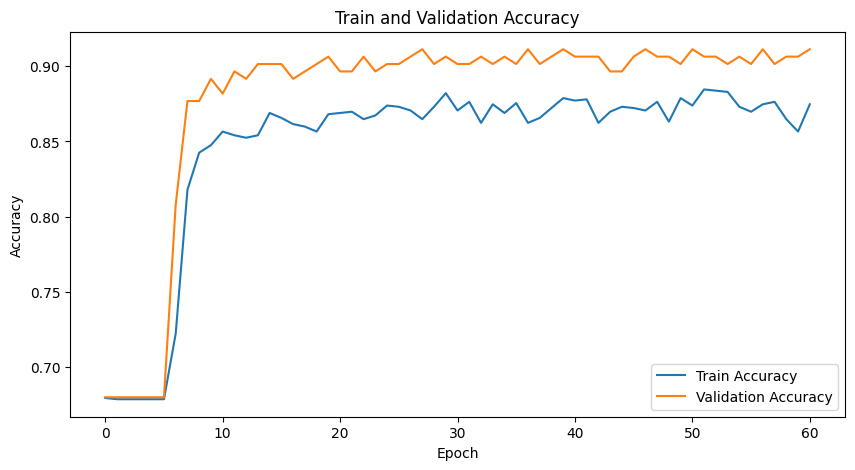

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(valid_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
resnet152.to('cuda')
resnet152.eval()
true_labels = []
predicted_probs = []
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = resnet152(images)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_probs.extend(probabilities[:, 1].tolist())
        true_labels.extend(labels.tolist())

true_labels = torch.tensor(true_labels).cpu().numpy()
predicted_probs = torch.tensor(predicted_probs).cpu().numpy()

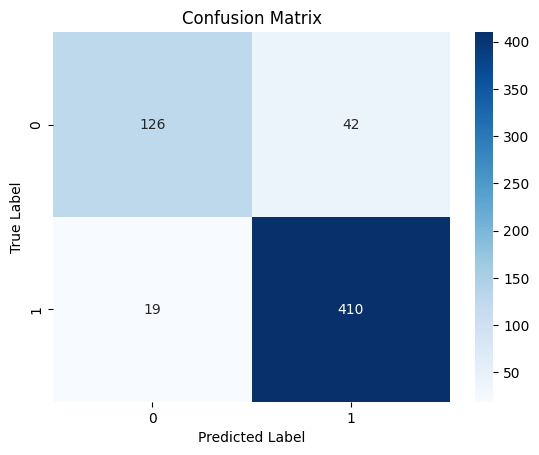



Test Accuracy: 0.897822445561139
Precision: 0.9070796460176991
Recall: 0.9557109557109557
F1-score: 0.9307604994324631
AUROC: 0.9523809523809523
AUCPR: 0.9805531734516826


In [ ]:
cm = confusion_matrix(true_labels, np.round(predicted_probs))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy = accuracy_score(true_labels, np.round(predicted_probs))
precision = precision_score(true_labels, np.round(predicted_probs))
recall = recall_score(true_labels, np.round(predicted_probs))
f1 = f1_score(true_labels, np.round(predicted_probs))
auroc = roc_auc_score(true_labels, predicted_probs)
aucpr = average_precision_score(true_labels, predicted_probs)
print('\n')
print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'AUROC: {auroc}')
print(f'AUCPR: {aucpr}')